导入相关模块。

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from beautify import (
    enlarge_eyes,
    smooth_skin,
    squeeze_face,
    whiten_hsi_clahe,
    whiten_lab_clahe,
    whiten_hsi_gamma,
    whiten_hsi_gain,
    whiten_lab_gain,
)
from blend import blend_image, feather_mask
from calibrate import undistort_image
from detect_face import get_face_mask
from preprocess import gaussian_filter, laplacian_sharpen, median_filter

读取内参矩阵和畸变系数。

In [2]:
params = np.load("../src/calib_params.npz")
K = params["camera_matrix"]
d = params["dist_coeffs"]
print(f"camera_matrix:\n{K}")
print(f"dist_coeffs:\n{d}")

camera_matrix:
[[1.84237531e+03 0.00000000e+00 1.24434538e+03]
 [0.00000000e+00 1.84905329e+03 1.74859952e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_coeffs:
[[ 0.03358079 -0.06483352  0.0004901   0.00100563  0.04323759]]


读取原始图像。

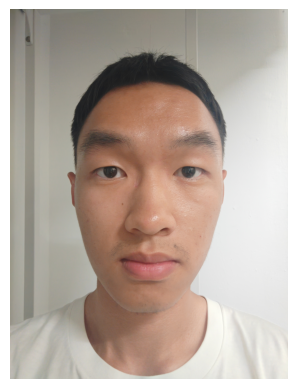

In [3]:
img = cv2.imread("../images/111.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

去畸变。

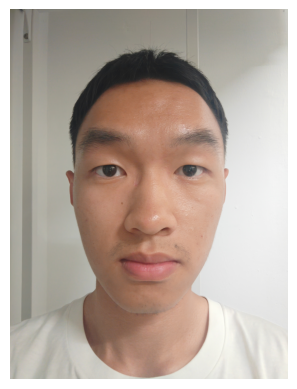

In [4]:
img1 = undistort_image(img, K, d)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

预处理，中值滤波+高斯滤波。

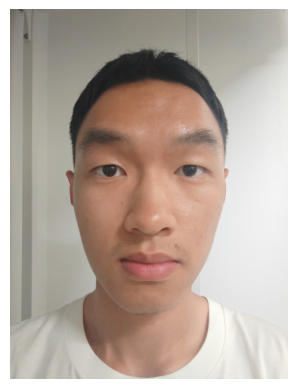

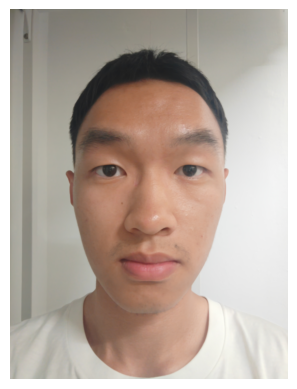

In [24]:
img2 = median_filter(img1, k_size=9)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

img3 = gaussian_filter(img2, k_size=25, sigma=2.0)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

预处理，拉普拉斯锐化。

(np.float64(-0.5), np.float64(2447.5), np.float64(3263.5), np.float64(-0.5))

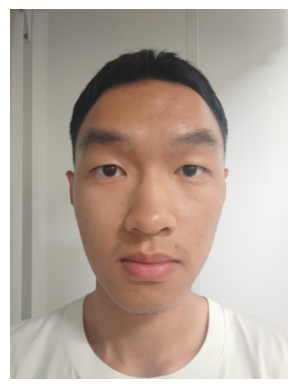

In [25]:
img4 = laplacian_sharpen(img3, alpha=1, k_size=1)
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.axis("off")

人脸区域分割。

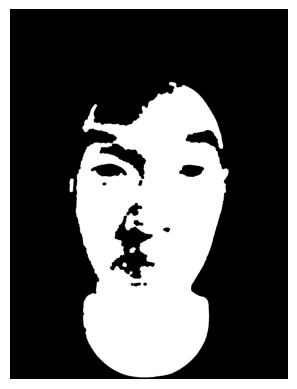

In [26]:
face_mask = get_face_mask(img4)
plt.imshow(face_mask, cmap="gray")
plt.axis("off")
plt.show()

美白。

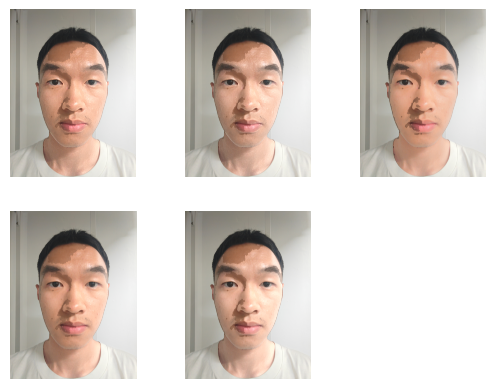

In [20]:
plt.subplot(2, 3, 1)
img51 = whiten_hsi_clahe(img4, face_mask, 2, (200, 200))
plt.imshow(cv2.cvtColor(img51, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

plt.subplot(2, 3, 2)
img52 = whiten_lab_clahe(img4, face_mask, 2.0, (200, 200))
plt.imshow(cv2.cvtColor(img52, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

plt.subplot(2, 3, 3)
img53 = whiten_hsi_gamma(img4, face_mask, gamma=0.65)
plt.imshow(cv2.cvtColor(img53, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

plt.subplot(2, 3, 4)
img54 = whiten_hsi_gain(img4, face_mask, gain_i=1.2, gain_s=1.0)
plt.imshow(cv2.cvtColor(img54, cv2.COLOR_BGR2RGB))
plt.axis("off")
# plt.show()

plt.subplot(2, 3, 5)
img55 = whiten_lab_gain(img4, face_mask, gain_l=1.25, gain_a=1.0, gain_b=1.0)
plt.imshow(cv2.cvtColor(img55, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

瘦脸。

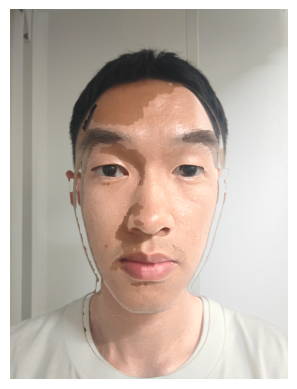

In [28]:
img6 = squeeze_face(img52, face_mask, gain=1.1)
plt.imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

大眼。

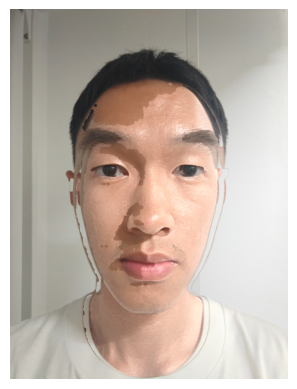

In [10]:
img7 = enlarge_eyes(img6, face_mask, gain=1.5, edge_low=5, edge_high=150, k_size=5)
plt.imshow(cv2.cvtColor(img7, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

磨皮。

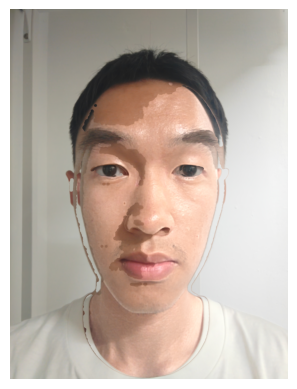

In [11]:
img8 = smooth_skin(img7, face_mask, diameter=9, sigma_color=75, sigma_space=75)
plt.imshow(cv2.cvtColor(img8, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

与原图像背景羽化融合。

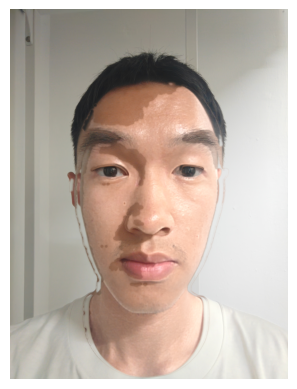

In [12]:
alpha = feather_mask(face_mask, radius=15)
img9 = blend_image(img8, img, alpha)
plt.imshow(cv2.cvtColor(img9, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()